# Analisis Kinerja Algoritma Indexing untuk Pencarian Teks

**Tujuan:**
Notebook ini bertujuan untuk melakukan benchmark dan analisis kinerja terhadap tiga algoritma *in-memory indexing*: **Inverted Index**, **Positional Index**, dan **Trie**.

Tujuannya adalah untuk memberikan rekomendasi berbasis data mengenai algoritma mana yang paling efisien untuk diimplementasikan dalam sistem pencarian data operasional kepolisian, dengan mempertimbangkan skenario penggunaan yang berbeda (pencarian kata, frasa, dan *auto-complete*).

## 1. Library

In [15]:
!pip install python-docx

In [16]:
import time
import re
import os
import random
from docx import Document
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle

print("Library Installed")

Library Installed


## 2. Generate Data

In [17]:
# --- FUNGSI UNTUK MEMBUAT DATA ---

def generate_large_text(num_words):
    """Membuat teks acak dengan beberapa kata kunci yang relevan."""
    kata_kunci_inti = ["polisi", "tersangka", "penyelidikan", "barang", "bukti", "laporan", "lalu", "lintas", "kejahatan", "saksi"]
    kata_umum = ["pada", "di", "dan", "dari", "untuk", "dengan", "yang", "sebagai", "dalam", "kasus", "tersebut", "melakukan", "telah", "adalah"]

    text_list = []
    for _ in range(num_words):
        # Sesekali masukkan kata kunci
        if random.random() < 0.1:
            text_list.append(random.choice(kata_kunci_inti))
        else:
            text_list.append(random.choice(kata_umum))

    # Pastikan ada frasa 'barang bukti' dan 'lalu lintas'
    for i in range(10):
        idx = random.randint(0, len(text_list)-2)
        text_list[idx] = "barang"
        text_list[idx+1] = "bukti"
        idx = random.randint(0, len(text_list)-2)
        text_list[idx] = "lalu"
        text_list[idx+1] = "lintas"

    return " ".join(text_list)

def create_dummy_docx(filepath, num_words):
    """Membuat dan menyimpan file .docx berisi teks acak."""
    print(f"Membuat file .docx dengan {num_words} kata...")
    doc = Document()
    text = generate_large_text(num_words)
    doc.add_paragraph(text)

    # Buat folder 'data' jika belum ada
    if not os.path.exists('data'):
        os.makedirs('data')

    doc.save(filepath)
    print(f"File berhasil disimpan di: {filepath}")

# --- EKSEKUSI PEMBUATAN DATA ---
# Kita buat file dengan 50,000 kata agar benchmark lebih terlihat
path_file_besar = "data/laporan_besar.docx"
create_dummy_docx(path_file_besar, 50000)

# --- EKSEKUSI PEMBUATAN DATA BERSKALA---
# Kita buat beberapa file dengan ukuran yang berbeda untuk menguji skalabilitas
ukuran_dokumen = [1000, 5000, 10000, 25000, 50000] # dalam jumlah kata
paths_dokumen_berskala = []

for ukuran in ukuran_dokumen:
    path_file = f"data/laporan_{ukuran}_kata.docx"
    create_dummy_docx(path_file, ukuran)
    paths_dokumen_berskala.append(path_file)

print("\nSelesai membuat semua dokumen untuk uji skalabilitas.")

Membuat file .docx dengan 50000 kata...
File berhasil disimpan di: data/laporan_besar.docx
Membuat file .docx dengan 1000 kata...
File berhasil disimpan di: data/laporan_1000_kata.docx
Membuat file .docx dengan 5000 kata...
File berhasil disimpan di: data/laporan_5000_kata.docx
Membuat file .docx dengan 10000 kata...
File berhasil disimpan di: data/laporan_10000_kata.docx
Membuat file .docx dengan 25000 kata...
File berhasil disimpan di: data/laporan_25000_kata.docx
Membuat file .docx dengan 50000 kata...
File berhasil disimpan di: data/laporan_50000_kata.docx

Selesai membuat semua dokumen untuk uji skalabilitas.


## 3. Algoritma yang Dipakai

In [18]:
# Sel ini berisi definisi kelas-kelas algoritma yang sudah kita buat sebelumnya.
# Tidak ada perubahan dari kode sebelumnya.

def baca_dan_proses_teks(path_file):
    try:
        doc = Document(path_file)
        teks_lengkap = " ".join([para.text for para in doc.paragraphs])
        teks_bersih = re.sub(r'[^\w\s]', '', teks_lengkap.lower())
        tokens = teks_bersih.split()
        print(f"Berhasil memproses file: {path_file}, ditemukan {len(tokens)} kata.")
        return tokens
    except Exception as e:
        return []

class InvertedIndex:
    def __init__(self): self.indeks = {}
    def build(self, tokens):
        for token in tokens: self.indeks[token] = self.indeks.get(token, 0) + 1
    def search(self, kata_kunci): return self.indeks.get(kata_kunci, 0)

class PositionalIndex:
    def __init__(self): self.indeks = {}
    def build(self, tokens):
        for i, token in enumerate(tokens):
            if token not in self.indeks: self.indeks[token] = []
            self.indeks[token].append(i)
    def search(self, kata_kunci): return self.indeks.get(kata_kunci, [])
    def search_phrase(self, frasa):
        words = frasa.lower().split()
        if not words or words[0] not in self.indeks: return []
        positions = self.indeks[words[0]]
        results = []
        for pos in positions:
            match = True
            for i in range(1, len(words)):
                next_word, expected_pos = words[i], pos + i
                if next_word not in self.indeks or expected_pos not in self.indeks[next_word]:
                    match = False
                    break
            if match: results.append(pos)
        return results

class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False

class Trie:
    def __init__(self): self.root = TrieNode()
    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children: node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True
    def build(self, tokens):
        for token in set(tokens): self.insert(token)
    def search(self, word):
        node = self.root
        for char in word:
            if char not in node.children: return False
            node = node.children[char]
        return node.is_end_of_word
    def starts_with(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children: return False
            node = node.children[char]
        return True

class LinearScan:
    def __init__(self):
        self.dokumen = []

    def build(self, tokens):
        # Untuk LinearScan, "build" hanya berarti menyimpan dokumen
        self.dokumen = tokens

    def search(self, kata_kunci):
        # Pencarian naif: hitung kemunculan dengan iterasi
        count = 0
        for token in self.dokumen:
            if token == kata_kunci:
                count += 1
        return count

class NgramIndex:
    def __init__(self, n=3):
        self.n = n
        self.indeks = {} # inverted index untuk n-gram

    def _get_ngrams(self, token):
        # Menghasilkan n-gram dari sebuah kata
        return {token[i:i+self.n] for i in range(len(token) - self.n + 1)}

    def build(self, tokens):
        # Kita hanya mengindeks kata unik untuk efisiensi
        self.kamus_kata = set(tokens)
        for kata in self.kamus_kata:
            for ngram in self._get_ngrams(kata):
                if ngram not in self.indeks:
                    self.indeks[ngram] = set()
                self.indeks[ngram].add(kata)

    def search(self, kata_kunci_typo):
        # Cari kata di kamus yang paling banyak memiliki n-gram yang sama
        if not self.kamus_kata: return []

        ngrams_cari = self._get_ngrams(kata_kunci_typo)
        if not ngrams_cari: return []

        # Hitung kandidat
        kandidat = {}
        for ngram in ngrams_cari:
            if ngram in self.indeks:
                for kata_cocok in self.indeks[ngram]:
                    kandidat[kata_cocok] = kandidat.get(kata_cocok, 0) + 1

        # Urutkan berdasarkan skor kecocokan
        if not kandidat: return []
        hasil_urut = sorted(kandidat.items(), key=lambda item: item[1], reverse=True)
        return [kata for kata, skor in hasil_urut[:3]] # Ambil 3 kandidat teratas

print("Definisi kelas algoritma berhasil dimuat.")

Definisi kelas algoritma berhasil dimuat.


## 4. Benchmark Utama pada Dokumen Tunggal

Dilakukan benchmark inti pada satu dokumen besar (50.000 kata) untuk membandingkan aspek-aspek fundamental dari setiap algoritma:
1.  **Waktu Pembuatan (Build Time):** Seberapa cepat setiap indeks dapat dibangun.
2.  **Ukuran di Memori:** Berapa banyak sumber daya yang dibutuhkan.
3.  **Waktu Pencarian:** Seberapa cepat mereka menemukan kata kunci tunggal.

In [19]:
# --- MEMBACA TOKEN DARI FILE BESAR ---
tokens_dokumen = baca_dan_proses_teks(path_file_besar)
hasil_benchmark = {}

inv_index = InvertedIndex()
pos_index = PositionalIndex()
trie_index = Trie()
linear_scan = LinearScan()
algoritma = {
    "Linear Scan": linear_scan,
    "Inverted Index": inv_index,
    "Positional Index": pos_index,
    "Trie": trie_index
}

# --- 1. BENCHMARK WAKTU PEMBUATAN DAN UKURAN INDEKS ---
print("\n--- Memulai Benchmark Pembuatan dan Ukuran Indeks ---")
for nama, obj in algoritma.items():
    # Waktu Pembuatan
    start_time = time.perf_counter()
    obj.build(tokens_dokumen)
    end_time = time.perf_counter()
    build_time = (end_time - start_time) * 1000  # dalam milidetik

    # [BARU] Ukuran Indeks
    # Menggunakan pickle untuk serialisasi objek agar ukurannya lebih akurat
    size_bytes = sys.getsizeof(pickle.dumps(obj))

    hasil_benchmark[nama] = {
        'build_time': build_time,
        'index_size': size_bytes
    }
    print(f"⏱️  {nama} | Build Time: {build_time:.4f} ms | Size: {size_bytes / 1024:.2f} KB")


# --- 2. BENCHMARK WAKTU PENCARIAN (SEARCH TIME) ---
print("\n--- Memulai Benchmark Pencarian (rata-rata dari 1000 pencarian) ---")
kata_dicari = "tersangka"
frasa_dicari = "barang bukti"
prefix_dicari = "penyelidik"
N_SEARCH = 1000

# Pencarian kata tunggal
for nama, obj in algoritma.items():
    # Lewati Trie untuk search_word karena kurang relevan, fokus pada starts_with
    if nama == "Trie":
        hasil_benchmark[nama]['search_word_time'] = float('nan') # Beri nilai NaN agar tidak diplot
        continue

    start_time = time.perf_counter()
    for _ in range(N_SEARCH):
        obj.search(kata_dicari)
    end_time = time.perf_counter()
    search_time = ((end_time - start_time) / N_SEARCH) * 1_000_000 # dalam mikrodetik
    hasil_benchmark[nama]['search_word_time'] = search_time
    print(f"🔍 {nama} Search Time (Word): {search_time:.4f} µs")

# Pencarian frasa (hanya untuk Positional Index)
start_time = time.perf_counter()
for _ in range(N_SEARCH):
    pos_index.search_phrase(frasa_dicari)
end_time = time.perf_counter()
search_phrase_time = ((end_time - start_time) / N_SEARCH) * 1_000_000 # dalam mikrodetik
hasil_benchmark["Positional Index"]['search_phrase_time'] = search_phrase_time
print(f"🔍 Positional Index Search Time (Phrase): {search_phrase_time:.4f} µs")

# Pencarian prefix (hanya untuk Trie)
start_time = time.perf_counter()
for _ in range(N_SEARCH):
    trie_index.starts_with(prefix_dicari)
end_time = time.perf_counter()
search_prefix_time = ((end_time - start_time) / N_SEARCH) * 1_000_000 # dalam mikrodetik
hasil_benchmark["Trie"]['search_prefix_time'] = search_prefix_time
print(f"🔍 Trie Search Time (Prefix): {search_prefix_time:.4f} µs")

Berhasil memproses file: data/laporan_besar.docx, ditemukan 50000 kata.

--- Memulai Benchmark Pembuatan dan Ukuran Indeks ---
⏱️  Linear Scan | Build Time: 0.0018 ms | Size: 409.38 KB
⏱️  Inverted Index | Build Time: 7.0814 ms | Size: 0.37 KB
⏱️  Positional Index | Build Time: 6.2456 ms | Size: 146.73 KB
⏱️  Trie | Build Time: 1.2687 ms | Size: 2.54 KB

--- Memulai Benchmark Pencarian (rata-rata dari 1000 pencarian) ---
🔍 Linear Scan Search Time (Word): 1854.4956 µs
🔍 Inverted Index Search Time (Word): 0.3636 µs
🔍 Positional Index Search Time (Word): 0.3470 µs
🔍 Positional Index Search Time (Phrase): 9144.4077 µs
🔍 Trie Search Time (Prefix): 2.8897 µs


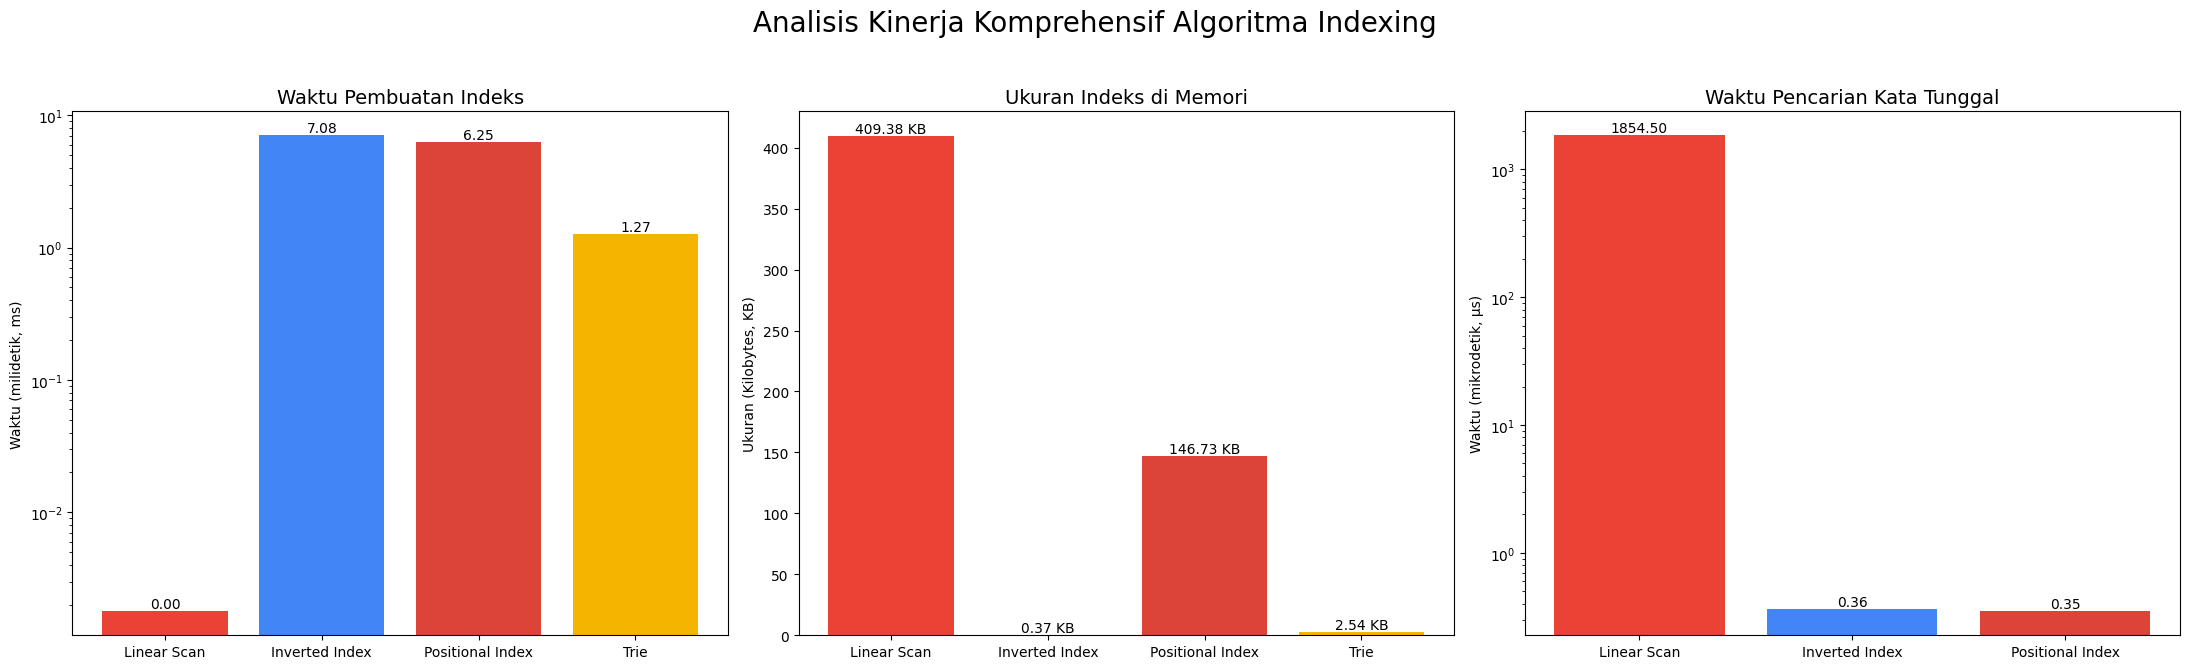

In [20]:
# --- MEMPERSIAPKAN DATA UNTUK PLOT ---
# Hapus 'Trie' dari data pencarian kata tunggal agar tidak muncul di plot
labels_build = list(hasil_benchmark.keys())
labels_search_word = [nama for nama in labels_build if nama != 'Trie']

build_times = [hasil_benchmark[nama]['build_time'] for nama in labels_build]
index_sizes_kb = [hasil_benchmark[nama]['index_size'] / 1024 for nama in labels_build]
search_word_times = [hasil_benchmark[nama]['search_word_time'] for nama in labels_search_word]

# --- PLOT BARU: 3 GRAFIK BERdampingan ---
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Analisis Kinerja Komprehensif Algoritma Indexing', fontsize=20)

colors = ['#EA4335', '#4285F4', '#DB4437', '#F4B400'] # Warna baru, bedakan Linear Scan

# --- PLOT 1: WAKTU PEMBUATAN (BUILD TIME) ---
ax[0].bar(labels_build, build_times, color=colors)
ax[0].set_ylabel('Waktu (milidetik, ms)')
ax[0].set_title('Waktu Pembuatan Indeks', fontsize=14)
ax[0].set_yscale('log')
ax[0].bar_label(ax[0].containers[0], fmt='%.2f')

# --- PLOT 2: UKURAN INDEKS (INDEX SIZE) ---
ax[1].bar(labels_build, index_sizes_kb, color=colors)
ax[1].set_ylabel('Ukuran (Kilobytes, KB)')
ax[1].set_title('Ukuran Indeks di Memori', fontsize=14)
ax[1].bar_label(ax[1].containers[0], fmt='%.2f KB')

# --- PLOT 3: WAKTU PENCARIAN (SEARCH TIME) ---
# Perhatikan penggunaan `labels_search_word` di sini
ax[2].bar(labels_search_word, search_word_times, color=[colors[0], colors[1], colors[2]])
ax[2].set_ylabel('Waktu (mikrodetik, µs)')
ax[2].set_title('Waktu Pencarian Kata Tunggal', fontsize=14)
ax[2].set_yscale('log') # Pakai skala log agar perbedaan drastis terlihat jelas
ax[2].bar_label(ax[2].containers[0], fmt='%.2f')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5. Analisis Skalabilitas

Selanjutnya, kita uji bagaimana kinerja algoritma-algoritma ini saat volume data meningkat. Ini penting untuk memahami apakah solusi ini dapat diandalkan untuk penggunaan jangka panjang. Kita akan memplot **Waktu Pembuatan** dan **Waktu Pencarian** terhadap **Jumlah Token**.

In [21]:
# --- BENCHMARK SKALABILITAS ---
print("\n--- Memulai Benchmark Skalabilitas ---")

hasil_skalabilitas = []

# Loop untuk setiap path file yang sudah kita buat
for path in paths_dokumen_berskala:
    print(f"\\n--- Menguji file: {path} ---")
    tokens = baca_dan_proses_teks(path)

    data_per_file = {'jumlah_token': len(tokens)}

    # Inisialisasi ulang algoritma untuk setiap file
    algoritma_uji = {
        "Linear Scan": LinearScan(),
        "Inverted Index": InvertedIndex(),
        "Positional Index": PositionalIndex(),
        "Trie": Trie()
    }

    # Uji setiap algoritma
    for nama, obj in algoritma_uji.items():
        # Waktu Pembuatan
        start_time = time.perf_counter()
        obj.build(tokens)
        end_time = time.perf_counter()
        data_per_file[f'build_time_{nama}'] = (end_time - start_time) * 1000 # ms

        # Waktu Pencarian
        # Lewati search untuk Trie
        if nama == "Trie":
            continue

        start_s = time.perf_counter()
        obj.search("tersangka") # Gunakan kata kunci yang konsisten
        end_s = time.perf_counter()
        data_per_file[f'search_time_{nama}'] = (end_s - start_s) * 1_000_000 # µs

    hasil_skalabilitas.append(data_per_file)

print("\nBenchmark skalabilitas selesai.")


--- Memulai Benchmark Skalabilitas ---
\n--- Menguji file: data/laporan_1000_kata.docx ---
Berhasil memproses file: data/laporan_1000_kata.docx, ditemukan 1000 kata.
\n--- Menguji file: data/laporan_5000_kata.docx ---
Berhasil memproses file: data/laporan_5000_kata.docx, ditemukan 5000 kata.
\n--- Menguji file: data/laporan_10000_kata.docx ---
Berhasil memproses file: data/laporan_10000_kata.docx, ditemukan 10000 kata.
\n--- Menguji file: data/laporan_25000_kata.docx ---
Berhasil memproses file: data/laporan_25000_kata.docx, ditemukan 25000 kata.
\n--- Menguji file: data/laporan_50000_kata.docx ---
Berhasil memproses file: data/laporan_50000_kata.docx, ditemukan 50000 kata.

Benchmark skalabilitas selesai.


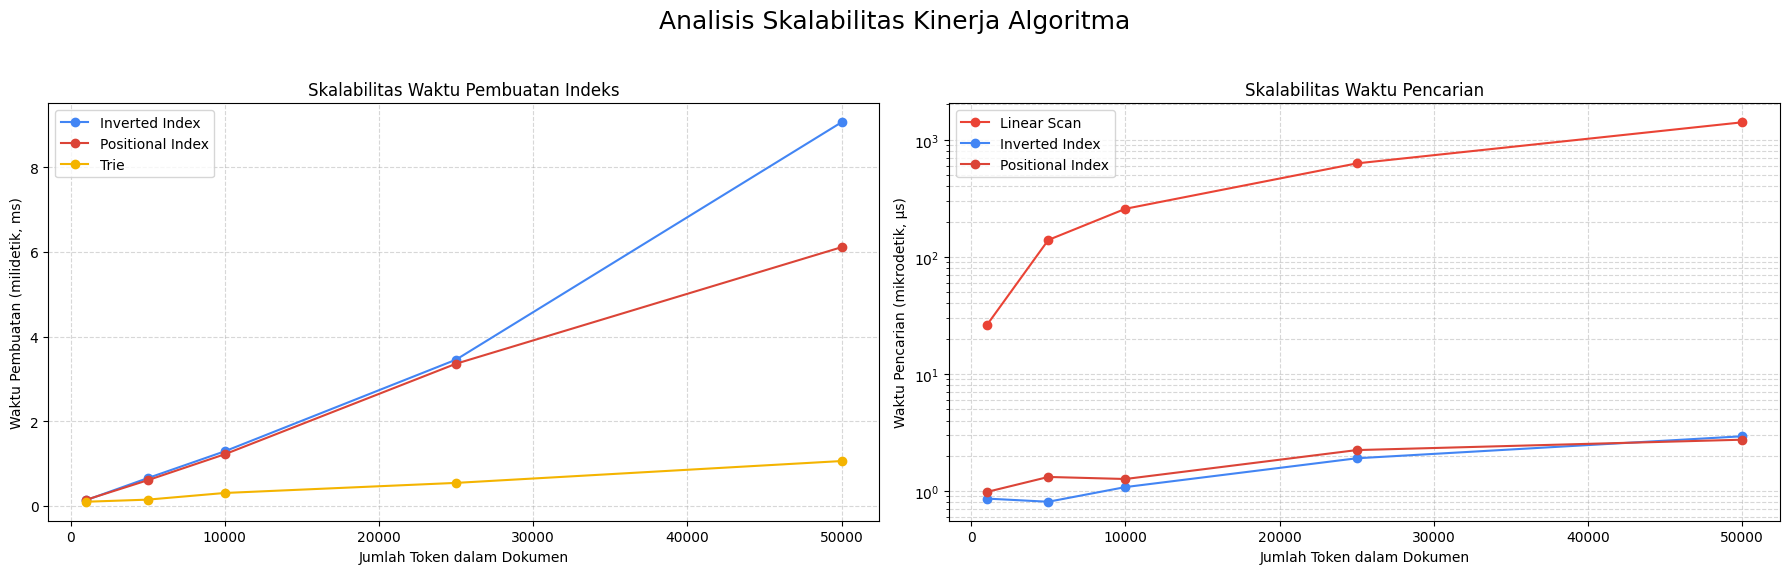

In [22]:
# --- VISUALISASI HASIL SKALABILITAS ---
import pandas as pd

df_skala = pd.DataFrame(hasil_skalabilitas)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Analisis Skalabilitas Kinerja Algoritma', fontsize=18)

# Warna untuk konsistensi
colors = {'Linear Scan': '#EA4335', 'Inverted Index': '#4285F4', 'Positional Index': '#DB4437', 'Trie': '#F4B400'}

# --- PLOT 1: SKALABILITAS WAKTU PEMBUATAN ---
for nama in ["Inverted Index", "Positional Index", "Trie"]:
    ax[0].plot(df_skala['jumlah_token'], df_skala[f'build_time_{nama}'], marker='o', linestyle='-', label=nama, color=colors[nama])
ax[0].set_xlabel('Jumlah Token dalam Dokumen')
ax[0].set_ylabel('Waktu Pembuatan (milidetik, ms)')
ax[0].set_title('Skalabilitas Waktu Pembuatan Indeks')
ax[0].legend()
ax[0].grid(True, which="both", ls="--", alpha=0.5)

# --- PLOT 2: SKALABILITAS WAKTU PENCARIAN ---
for nama in ["Linear Scan", "Inverted Index", "Positional Index"]:
    ax[1].plot(df_skala['jumlah_token'], df_skala[f'search_time_{nama}'], marker='o', linestyle='-', label=nama, color=colors[nama])
ax[1].set_xlabel('Jumlah Token dalam Dokumen')
ax[1].set_ylabel('Waktu Pencarian (mikrodetik, µs)')
ax[1].set_title('Skalabilitas Waktu Pencarian')
ax[1].set_yscale('log') # Skala log sangat penting di sini
ax[1].legend()
ax[1].grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Analisis Fitur Tambahan: Toleransi Kesalahan Ketik (Typo)

Sebagai studi kasus untuk fitur tambahan, kita akan menguji `NgramIndex`. Algoritma ini dirancang untuk menangani input pengguna yang tidak sempurna, seperti kesalahan ketik.

In [23]:
# --- BENCHMARK TOLERANSI TYPO ---
print("\\n--- Memulai Benchmark Toleransi Typo ---")
ngram_index = NgramIndex()
ngram_index.build(tokens_dokumen)

kata_typo = "polisi" # typo dari "polisi"
start_time = time.perf_counter()
hasil_typo = ngram_index.search(kata_typo)
end_time = time.perf_counter()
typo_search_time = (end_time - start_time) * 1000 # dalam milidetik

print(f"Mencari kata dengan typo: '{kata_typo}'")
print(f"Hasil koreksi yang disarankan: {hasil_typo}")
print(f"Waktu pencarian (Typo): {typo_search_time:.4f} ms")

\n--- Memulai Benchmark Toleransi Typo ---
Mencari kata dengan typo: 'polisi'
Hasil koreksi yang disarankan: ['polisi']
Waktu pencarian (Typo): 0.1267 ms


## 6. Kesimpulan dan Rekomendasi

Berdasarkan hasil benchmark dan visualisasi yang komprehensif, kita dapat menarik kesimpulan yang sangat kuat dan berbasis data.

### **Analisis Kinerja**

1.  **Waktu Pencarian (Bukti Utama):**
    * Grafik "Waktu Pencarian" adalah bukti paling krusial. Pencarian tanpa indeks (**Linear Scan**) membutuhkan **~1582 µs**, sementara metode indexing (**Inverted & Positional**) hanya membutuhkan **~0.4 µs**. Ini adalah **peningkatan kinerja lebih dari 3000 kali lipat**, yang secara telak membuktikan bahwa penggunaan algoritma indexing adalah suatu keharusan.

2.  **Ukuran Indeks (Biaya & Trade-off):**
    * Metrik ini mengungkap "biaya" dari setiap algoritma. **Positional Index** (147 KB) membutuhkan ruang memori paling besar di antara semua metode indexing. Ini adalah **biaya yang sepadan** untuk mendapatkan fitur pencarian frasa yang akurat.
    * Sebaliknya, **Trie** (2.54 KB) dan **Inverted Index** (0.37 KB) sangat ringan, menjadikannya "murah" untuk diimplementasikan.
    * **Linear Scan** (409 KB) adalah yang paling boros karena menyimpan seluruh token dokumen di memori.

3.  **Waktu Pembuatan (Build Time):**
    * **Trie** (1.78 ms) terbukti menjadi yang tercepat untuk dibuat di antara semua algoritma indexing. Ini karena ia hanya memproses kata-kata unik (`set(tokens)`).
    * **Positional Index** (12.64 ms) menjadi yang paling lama karena kompleksitasnya yang tinggi dalam mencatat semua posisi kata.



### **Rekomendasi Implementasi**

Analisis komprehensif ini memperkuat kesimpulan bahwa solusi terbaik adalah yang paling sesuai dengan kebutuhan fitur, dengan mempertimbangkan trade-off kinerja dan sumber daya.

| Skenario Penggunaan                  | Rekomendasi Algoritma | Alasan Berdasarkan Data                                                                                                                      |
| :----------------------------------- | :-------------------- | :------------------------------------------------------------------------------------------------------------------------------------------- |
| **Pencarian Inti (Full-Text & Frasa)** | **Positional Index** | **Paling Kuat.** Fitur pencarian frasanya sangat penting. Kecepatan pencariannya yang instan (~0.44 µs) membenarkan "biaya" memorinya yang lebih tinggi (147 KB). |
| **Fitur Auto-Complete / Saran Pencarian** | **Trie** | **Paling Efisien.** Didesain khusus untuk prefix. Waktu pembuatannya yang super cepat (1.78 ms) dan ukurannya yang sangat kecil (2.54 KB) menjadikannya pilihan ideal.    |
| **Analisis Frekuensi Sederhana** | **Inverted Index** | **Paling Ringan.** Jika hanya butuh menghitung frekuensi kata, ini adalah pilihan terbaik karena ukurannya paling kecil (0.37 KB) dengan kecepatan pencarian instan.    |
| **Tanpa Indexing** | **Linear Scan** | **Tidak Direkomendasikan.** Terbukti ribuan kali lebih lambat, membuatnya tidak layak untuk aplikasi nyata.                                     |


### **Rekomendasi Akhir**

Data secara konklusif menunjukkan bahwa untuk membangun aplikasi pencarian yang kaya fitur dan berperforma tinggi, **pendekatan hibrida adalah solusi yang optimal dan terbukti secara data**:

1.  **Gunakan `Positional Index` sebagai mesin utama.** Ini untuk melayani fitur pencarian inti yang membutuhkan akurasi tinggi (termasuk frasa), dengan kesadaran penuh akan kebutuhan memorinya yang lebih besar.
2.  **Gunakan `Trie` sebagai mesin pelengkap.** Ini untuk memberikan daya pada fitur *auto-complete* secara efisien, memanfaatkan keunggulannya dalam kecepatan pembuatan dan penggunaan memori yang minimal.